# Lab 10: Monte Carlo Tree Search in Games

## Setup (run & skip)

We will use [OpenSpiel](https://github.com/deepmind/open_spiel) again.

In [12]:
# *Important*:
# This takes a while: ~10min, so it's better to do before the lab starts.
#
# Currently, it prints some errors about dependency versions, but those 
# packages are not relevant to what we will use in the lab, so it is ok.
!pip install open_spiel tqdm

# Let's make some imports
from typing import Callable, Dict, List, Tuple, Union
import functools
import itertools

import numpy as np
import pyspiel
import tqdm
import copy

from collections import defaultdict


[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Monte Carlo Tree Search

**Question:** Explain the main idea of MCTS.



### MCTS loop

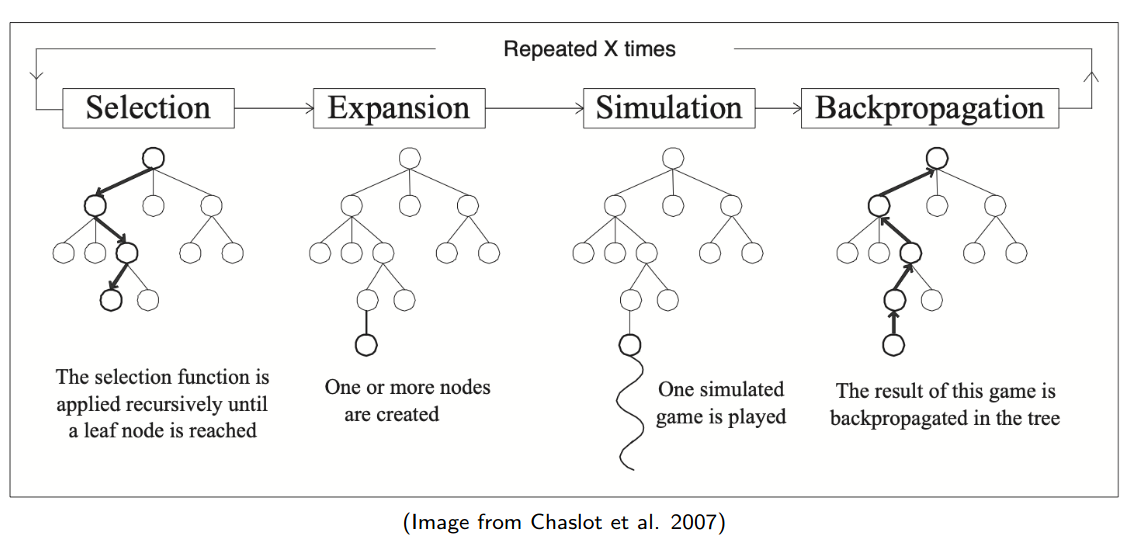

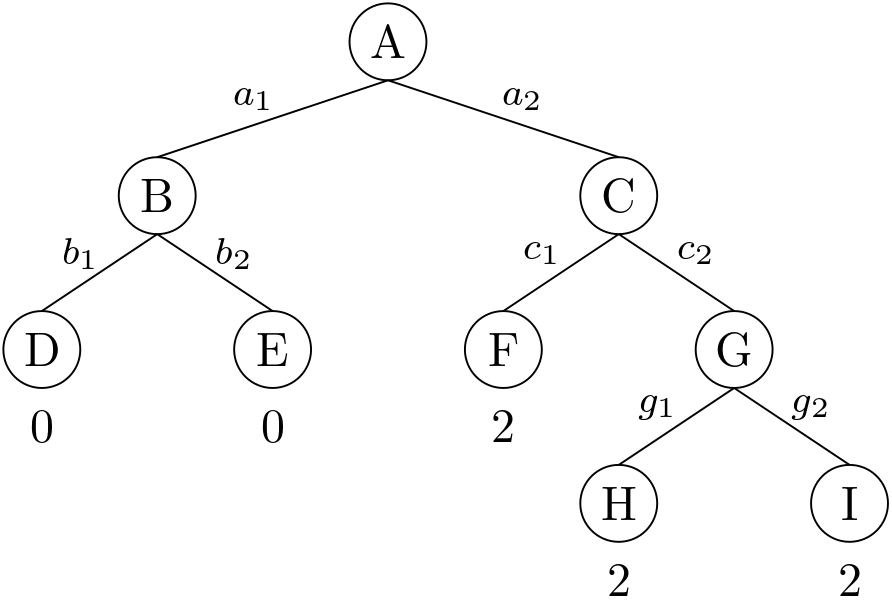

$$ Q(s, a) + c * \sqrt{ \frac{\ln n_s}{n_{s,a}}} $$

That is, keep:
 - average values
 - number of times a node was accessed

Hint: you have the total number of the corresponding branch in the parent node.

**Question:**
Consider UCT algorithm with exploration constant **c = 2**; assume that we **break ties** between actions **in favor of the left one** and **random rollout**. What part of the game tree will be built after 5 iterations of UCT algorithm. (perform on the whiteboard)



### MCTS algorithm

Let's create stateful bandits -- this is essentially the same thing we did in previous labs.

In [14]:
# We need to distinguish between _actions_ and _action_indices_ !!
Action = int

class Bandit:
    def total_visits(self) -> int:
        raise NotImplementedError()
    
    def select(self) -> Action:
        raise NotImplementedError()
    
    def update(self, value: float) -> None:
        raise NotImplementedError()        
    
    def best_action(self) -> Action:
        raise NotImplementedError()
        

class EpsGreedyBandit(Bandit):
    def __init__(self, state: pyspiel.State, epsilon: float):
        self.epsilon = epsilon
        self.actions = state.legal_actions()
        self.qs = np.zeros(len(self.actions))
        self.visits = np.zeros(len(self.actions))
        self.last_idx = None

    def select(self) -> Action:
        if np.random.rand() < self.epsilon:
            self.last_idx = np.random.randint(len(self.actions))
        else:
            self.last_idx = np.argmax(self.qs)
            
        return self.actions[self.last_idx]

    def update(self, value: float) -> None:
        self.visits[self.last_idx] += 1
        self.qs[self.last_idx] += (value - self.qs[self.last_idx]) \
                                  / self.visits[self.last_idx]
        
    def best_action(self) -> Action:
        return self.actions[np.argmax(self.qs)]


class UcbBandit(Bandit):

    def __init__(self, state: pyspiel.State, c_uct):
        self.c_uct = c_uct
        self.actions = state.legal_actions()
        self.qs = np.zeros(len(self.actions))
        self.visits = np.zeros(len(self.actions))  
        self.last_idx = None

    def total_visits(self) -> int:
        return np.sum(self.visits)

    def select(self) -> Action:
        # implement
        # save self.last_idx with the selected action

        ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
        self.last_idx = np.argmax(ucbs)
        return self.actions[self.last_idx]

        # best_ucb = -np.inf
        # best_action = None
        # for action in self.actions:
        #     cur_ucb = self.qs[action] + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits[action])
        #     if cur_ucb > best_ucb:
        #         best_ucb = cur_ucb
        #         best_action = action
        #
        # self.last_idx = best_action
        # return best_action
        
    def update(self, value: float) -> None:
        self.visits[self.last_idx] += 1
        self.qs[self.last_idx] += (value - self.qs[self.last_idx]) \
                                  / self.visits[self.last_idx]
    def best_action(self) -> Action:
        return self.actions[np.argmax(self.qs)]

Let's implement MCTS. 


**Question**: How to represent the search tree?



In [15]:
Trace = List[pyspiel.State]

def random_simulation(state: pyspiel.State) -> List[float]:
    while not state.is_terminal():
        random_action = np.random.choice(state.legal_actions())
        state.apply_action(random_action)

    return state.returns()

def node_depth(node: tuple) -> int:
  return len(node)

class MCTS:
    def __init__(self, bandit_factory: Callable[[pyspiel.State], Bandit], 
                       simulate: Callable[[pyspiel.State], List[float]]):
        self.node_table: Dict[tuple, Bandit] = dict()
        self.bandit_factory = bandit_factory
        self.simulate = simulate

    def has_node(self, state: pyspiel.State) -> bool:
        return tuple(state.history()) in self.node_table

    def get_node(self, state: pyspiel.State) -> Bandit:
        return self.node_table[tuple(state.history())]

    def make_node(self, state: pyspiel.State):
        self.node_table[tuple(state.history())] = self.bandit_factory(state)

    def deepest_node(self) -> int:
        return max(node_depth(node) for node in self.node_table.keys())

    def node_stats(self) -> Dict[int, int]:
      # Count the number of visited nodes at each depth. 
      nodes = sorted(self.node_table.keys())
      node_stats = defaultdict(int)

      for node in nodes:
        node_stats[node_depth(node)] += 1
      
      return node_stats

    def best_action(self, state: pyspiel.State) -> Action:
        return self.get_node(state).best_action()

    def step(self, state: pyspiel.State):
      # An invariant we rely on: there is always a bandit available 
      # for the current state to search from.
      if not self.has_node(state):
          self.make_node(state)

      # Therefore, there is always a trace:
      trace, last_state = self.select(state.clone())

      # Compute values, either by asking the game, or by making a simulation.
      if last_state.is_terminal():
          values = last_state.returns()
      else:
          self.expand(last_state)
          values = self.simulate(last_state.clone())

      # Backpropagate the values to make bandit updates along the trace,
      # except for the last node on the trace -- the leaf or the terminal.
      self.backpropagate(trace, values)

    def select(self, state: pyspiel.State) -> Tuple[Trace, pyspiel.State]:
        trace = [] # <- push state.clone() here

        # Task: implement
        while self.has_node(state):
            if state.is_terminal():
                break

            trace.append(state.clone())
            bandit = self.get_node(state)
            best_action = bandit.select()
            state.apply_action(best_action)

        return trace, state.clone() # trace & last_state

    def expand(self, state: pyspiel.State) -> None:
        self.make_node(state)

    def backpropagate(self, trace: Trace, values: List[float]) -> None:
        for state in reversed(trace):
          self.get_node(state).update(values[state.current_player()])


## MCTS analysis

We will be evaluating MCTS on the game of [connect four](https://en.wikipedia.org/wiki/Connect_Four). 

![](https://upload.wikimedia.org/wikipedia/commons/a/ad/Connect_Four.gif)

In [16]:
game = pyspiel.load_game("connect_four")
state = game.new_initial_state()
for i in range(8):
  state.apply_action(np.random.choice(state.legal_actions()))
state

.......
.......
.......
.....x.
.....o.
.xoxxoo

**Question**: What is your intuition: what is the game value and where should the first player play?



**Question**: What is the deepest node in C4?



In [19]:
# Run & Skip
num_steps = 10000
record_step = 100

# Helper functions to record statistics
def record_mcts_stats(mcts: MCTS) -> None:
  game = pyspiel.load_game("connect_four")
  state = game.new_initial_state()

  stats = []
  for i in tqdm.tqdm(range(num_steps)):
    mcts.step(state)
    if i % record_step == 0:
      root_node = mcts.get_node(state)
      stats.append(dict(
          deepest_node=mcts.deepest_node(),
          qs=copy.copy(root_node.qs),
          visits=copy.copy(root_node.visits),
          best_action=root_node.best_action(),
          node_stats=mcts.node_stats()
      ))
  return stats

# Functions for plotting statistics
import matplotlib.pyplot as plt

y_labels = {
    "deepest_node" : "Largest depth",
    "qs" : "Q-values | Q(s,a)",
    "visits" : "Action tries | N(s, a)",
    "best_action" : "Best action"
}

def plot_stats(stats, to_plot=["deepest_node", "visits", "qs", "best_action"], title=''):
  fig, axes = plt.subplots(nrows=len(to_plot), ncols=1, squeeze=False, sharex=True, figsize=(13,5 * len(to_plot)))

  i = 0
    
  if title != '':
      axes[0, 0].set_title(title)
    
  for stat in to_plot:
      axes[i, 0].set_ylabel(y_labels[stat])
      axes[i, 0].set_xlabel("steps")
      axes[i, 0].plot(range(0, num_steps, record_step), [rec[stat] for rec in stats])
      if stat == "best_action":
            axes[i, 0].set_ylim([0, 6])
      axes[i, 0].tick_params(labelbottom=True)
      
      if len(axes[i, 0].lines) > 1:
        act = 0
        for line in axes[i, 0].lines:
            line.set_label("Action " + str(act))
            act += 1
        axes[i, 0].legend()
      i += 1

def plot_depth_histogram(stats, indices, record_step, title=""):
  fig, axes = plt.subplots(nrows=1, ncols=len(indices), 
                           squeeze=False, figsize=(6*len(indices),4))
  for i, idx in enumerate(indices):
    ax = axes[0][i]
    data = stats[idx]["node_stats"]
    # dicts can have wrong order... make into sorted tuples
    data = [(k,v) for k, v in data.items()]
    data = sorted(data, key=lambda kv: kv[0])
    sorted_keys = [k for k,v in data]
    sorted_values = [v for k,v in data]
    ax.set_title(f"After {idx*record_step} steps")
    ax.bar(range(len(data)), sorted_values, tick_label=sorted_keys)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Visited nodes")
    
  if title != "":
    fig.suptitle(title, fontsize=16)

Let's run MCTS with $\epsilon$-greedy/UCB bandits and random simulations.

While gradually increasing the number of steps, we will show:
- the largest depth the algorithm reaches
- Q-values and the number of tries for each action in the root node
- the best action to take in the root node
- depth histograms

**Question** To understand the following graphs, let's think about what is the possible range of: largest depth / Q values / visit counts / best action?



100%|██████████| 10000/10000 [00:02<00:00, 4716.62it/s]


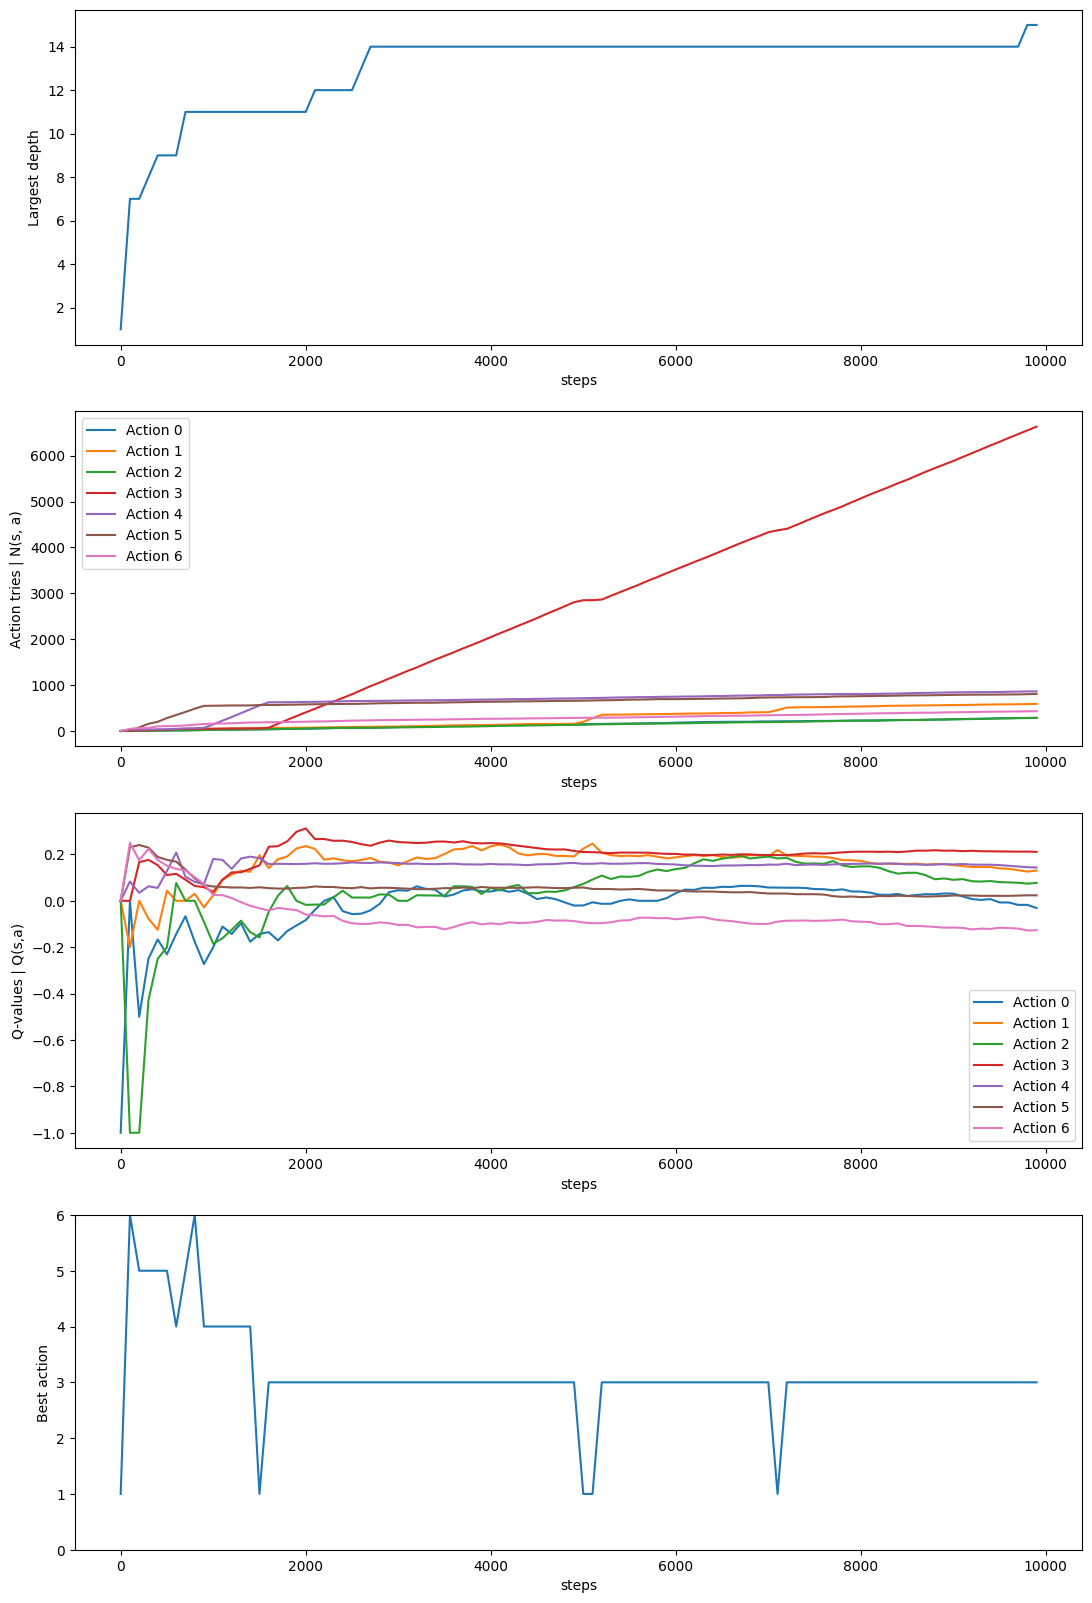

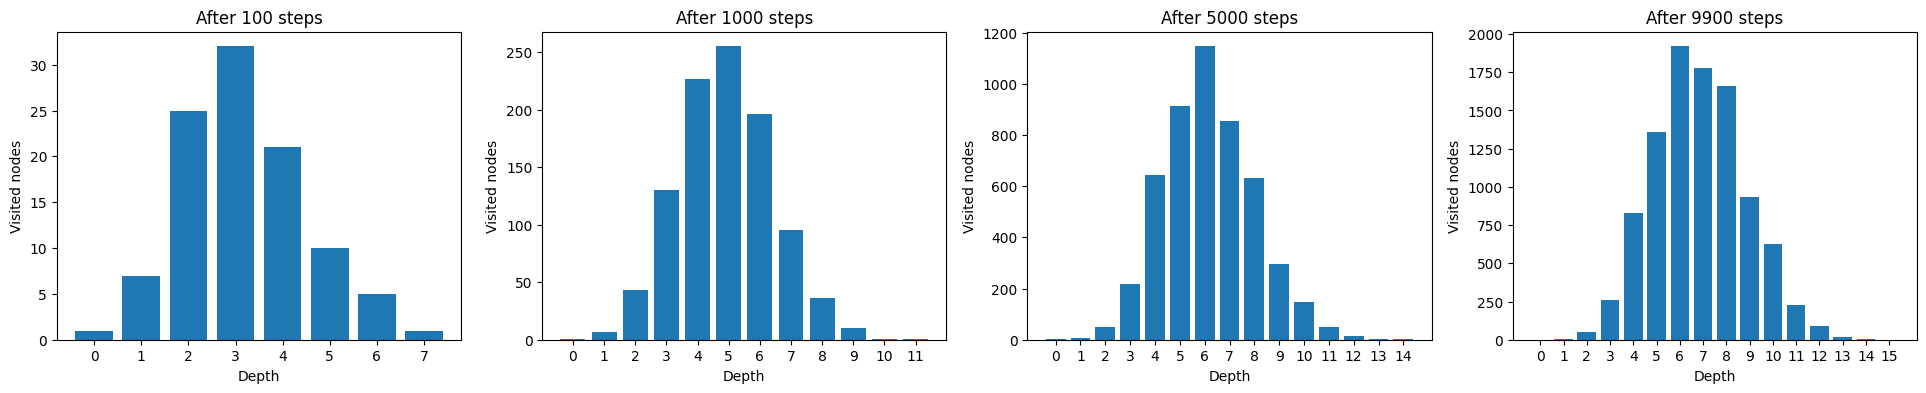

In [20]:
# MCTS with epsilon-greedy bandit

np.random.seed(111111)
mcts = MCTS(lambda state: EpsGreedyBandit(state, epsilon=0.2), random_simulation)
statsEGB = record_mcts_stats(mcts)
plot_stats(statsEGB)
plot_depth_histogram(statsEGB, [1, 10, 50, 99], record_step=record_step)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: divide by zero encountered in log
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: invalid value encountered in sqrt
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: invalid value encountered in divide
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
100%|██████████| 10000/10000 [00:02<00:00, 4199.02it/s]


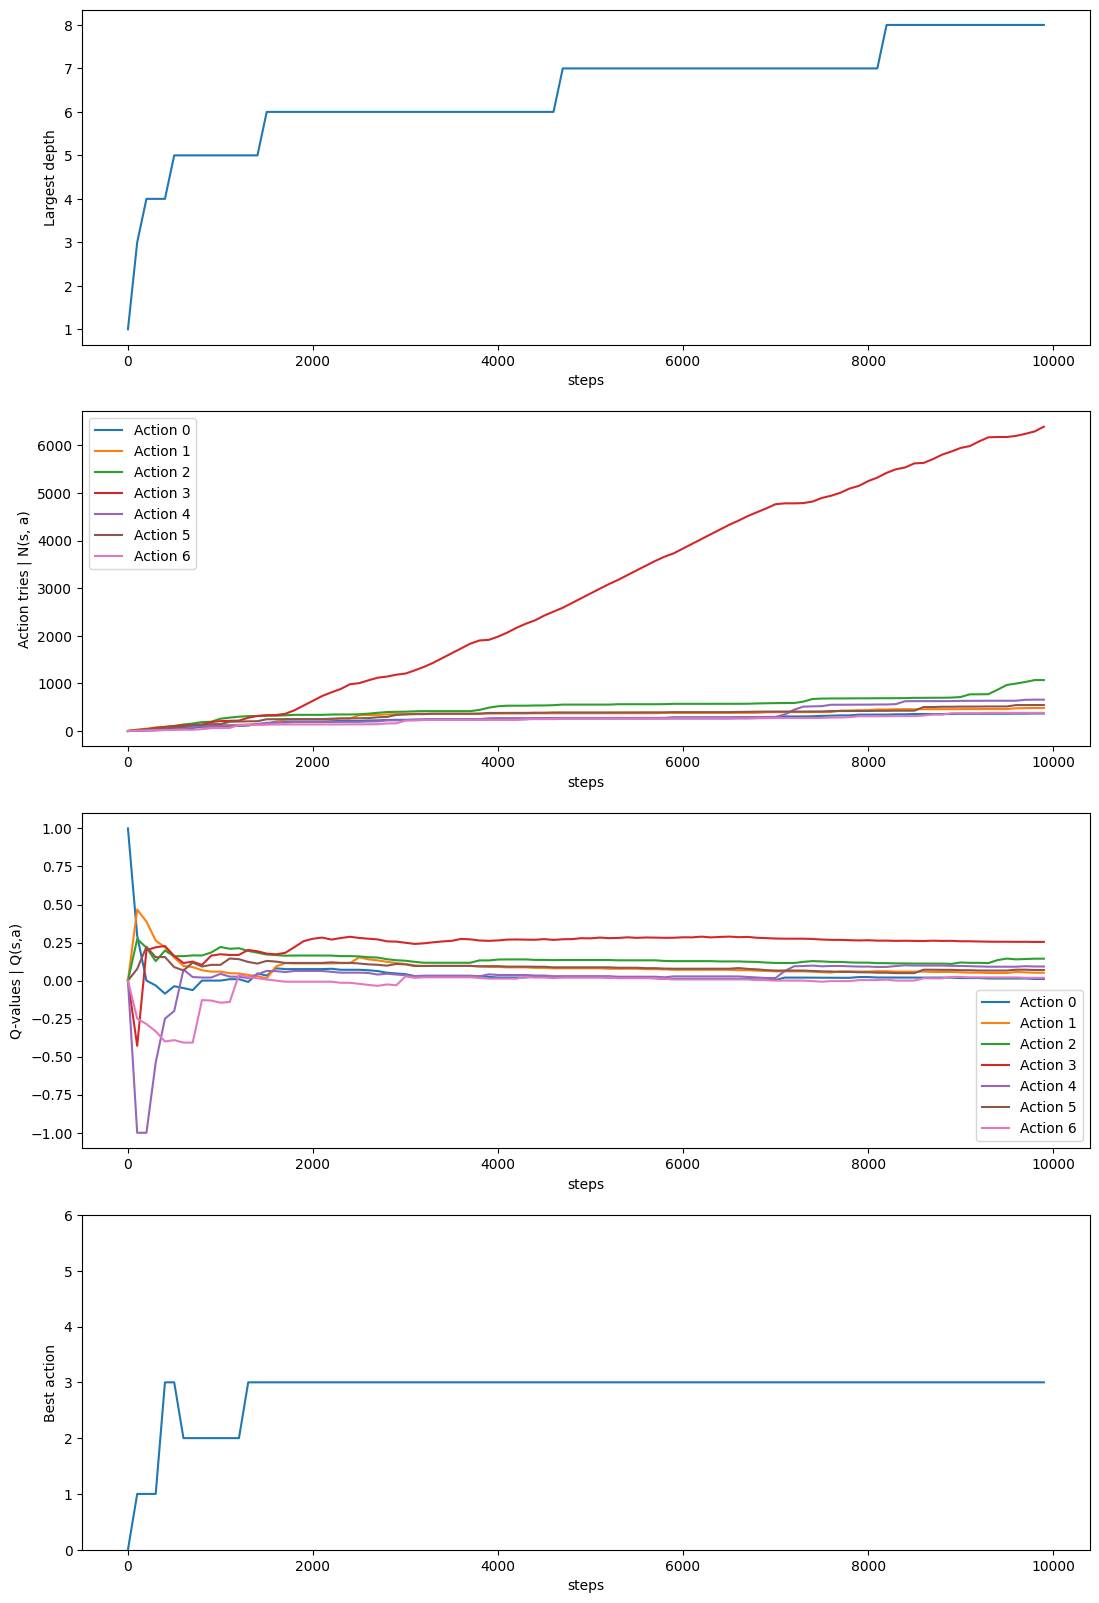

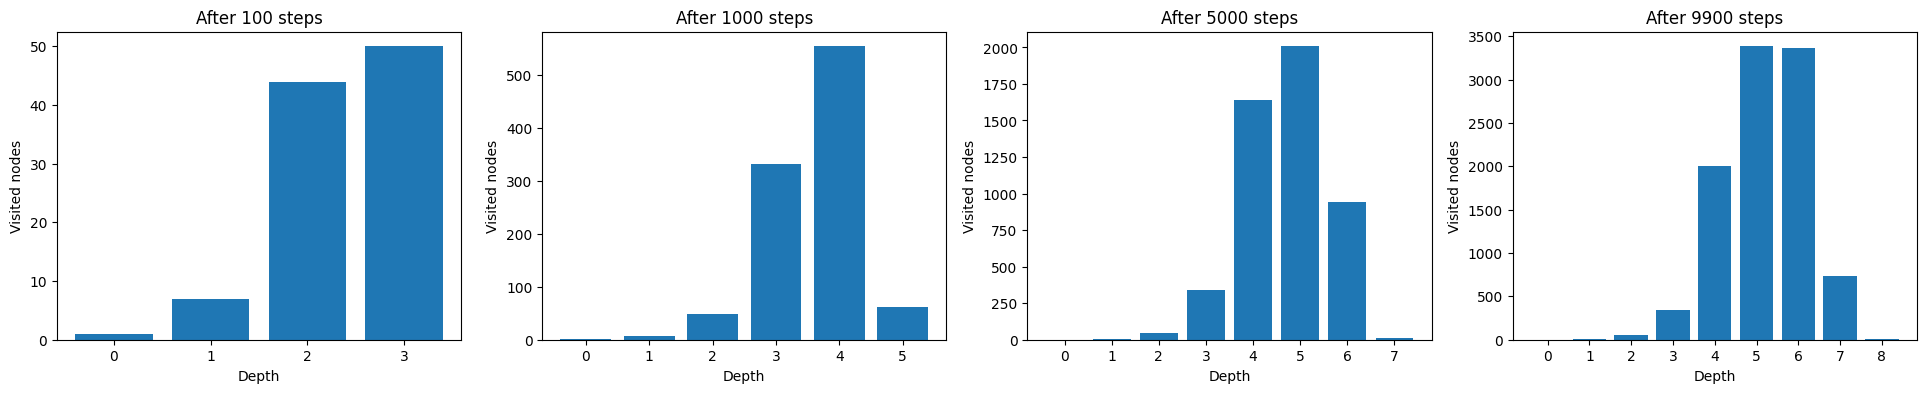

In [22]:
# MCTS with UCB bandit

np.random.seed(111111)
mcts = MCTS(lambda state: UcbBandit(state, c_uct=2), random_simulation)
statsUCT = record_mcts_stats(mcts)
plot_stats(statsUCT)
plot_depth_histogram(statsUCT, [1, 10, 50, 99], record_step=record_step)

**Question** Note the visit counts for UCT "takes off" after some number of steps (plot 2). Can you explain this behaviour? (see plot **below**)



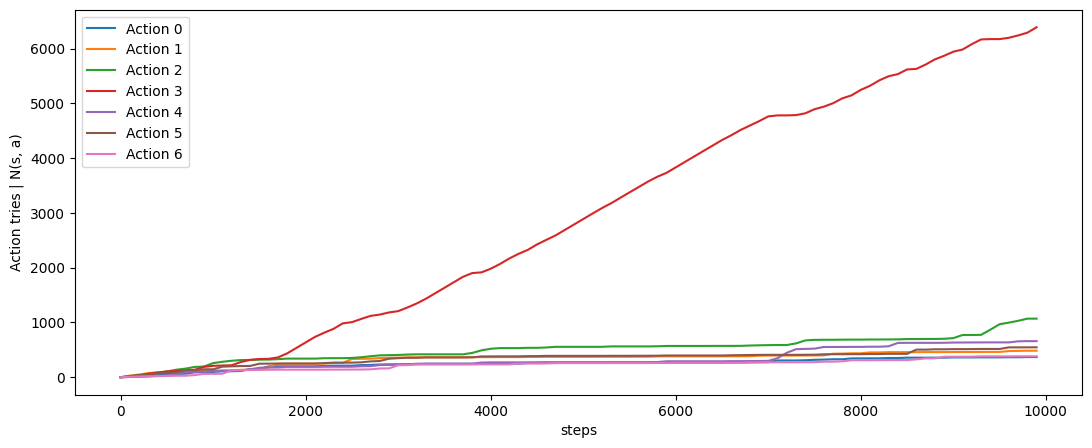

In [25]:
# Just plot "visits" stats from previously recorded stats for UCT
plot_stats(statsUCT, to_plot=['visits'])

**Question** Compare the depth and Q-values evolution of UCT and MCTS with `EpsGreedyBandit`. (see plots **below**)



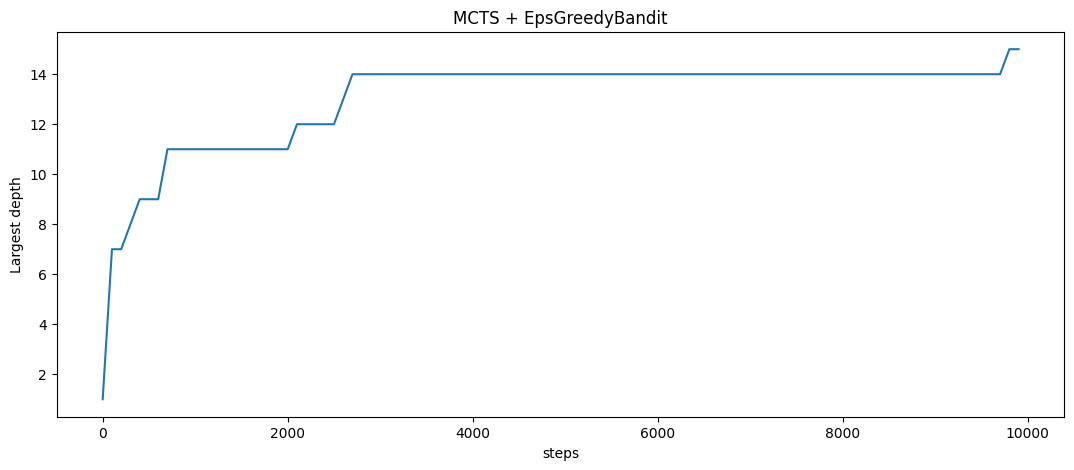

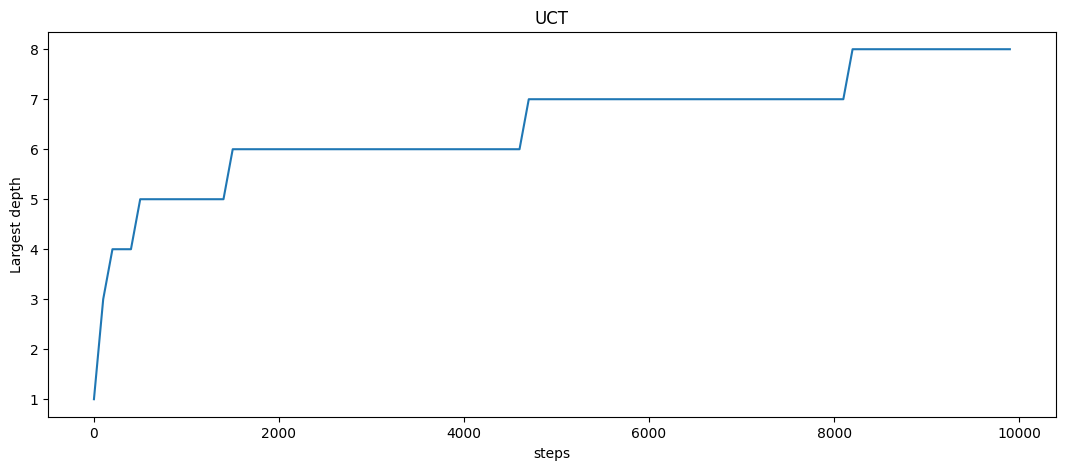

In [24]:
# Just plot "deepest node" stats from previously recorded stats
plot_stats(statsEGB, ["deepest_node"], "MCTS + EpsGreedyBandit")
plot_stats(statsUCT, ["deepest_node"], "UCT")

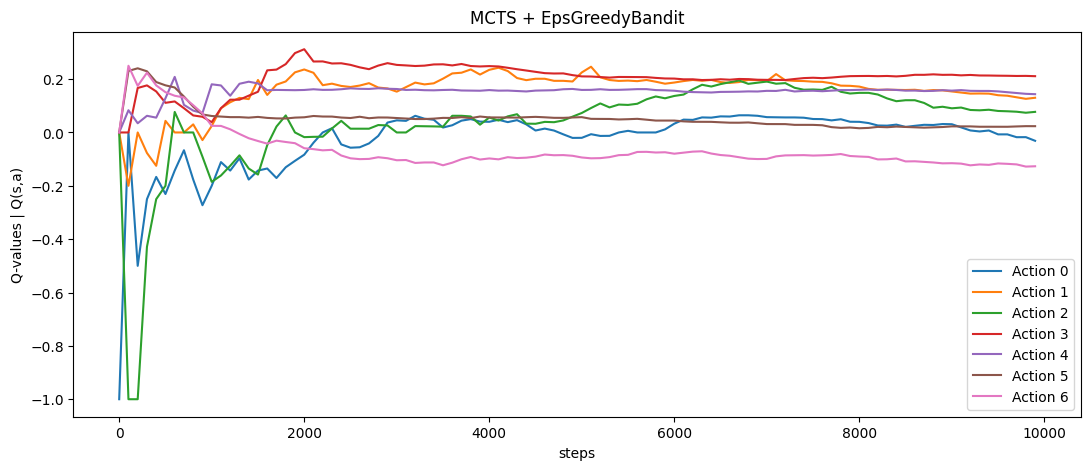

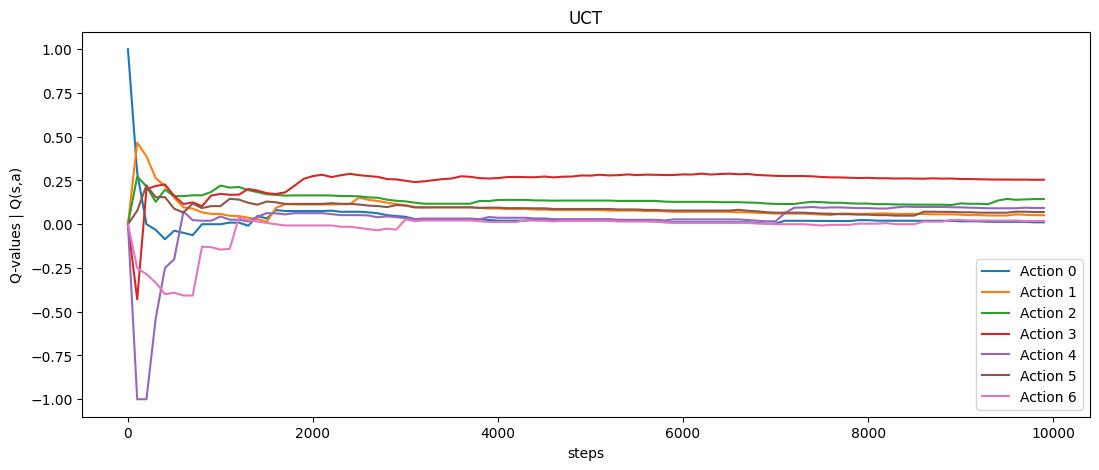

In [23]:
# Just plot "Q-values" stats from previously recorded stats
plot_stats(statsEGB, ["qs"], "MCTS + EpsGreedyBandit")
plot_stats(statsUCT, ["qs"], "UCT")

**Question:** What should we do to reach deeper levels of the game tree when using MCTS with `EpsGreedyBandit`?



100%|██████████| 10000/10000 [00:02<00:00, 4982.27it/s]


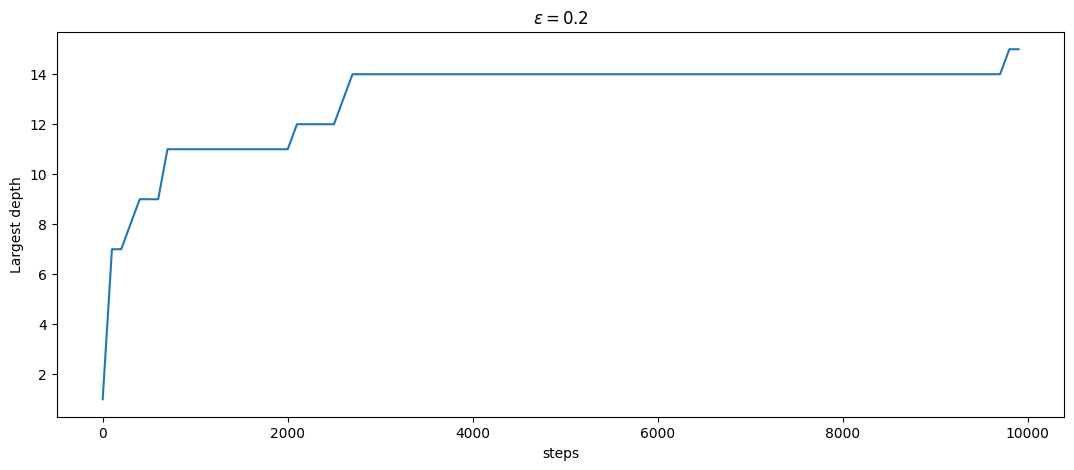

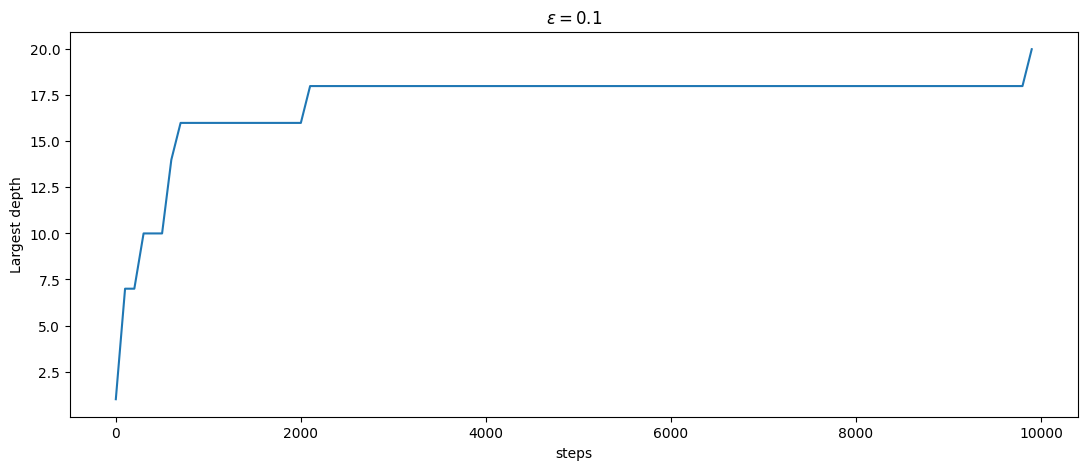

In [26]:
np.random.seed(111111)
mcts = MCTS(lambda state: EpsGreedyBandit(state, epsilon=0.2), random_simulation)
stats = record_mcts_stats(mcts)
plot_stats(stats, to_plot=["deepest_node"], title=r'$\epsilon = 0.2$')

np.random.seed(111111)
mcts = MCTS(lambda state: EpsGreedyBandit(state, epsilon=0.1), random_simulation)
stats = record_mcts_stats(mcts)
plot_stats(stats, to_plot=["deepest_node"], title=r'$\epsilon = 0.1$')

**Question:** What should we do to do more exploring when using MCTS with `UcbBandit`?



  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: divide by zero encountered in log
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: invalid value encountered in sqrt
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: invalid value encountered in divide
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: divide by zero encountered in log
  ucbs = self.qs + self.c_uct * np.sqrt(np.log(self.total_visits()) / self.visits)
/tmp/ipykernel_5554/714734879.py:59: RuntimeWarning: invalid va

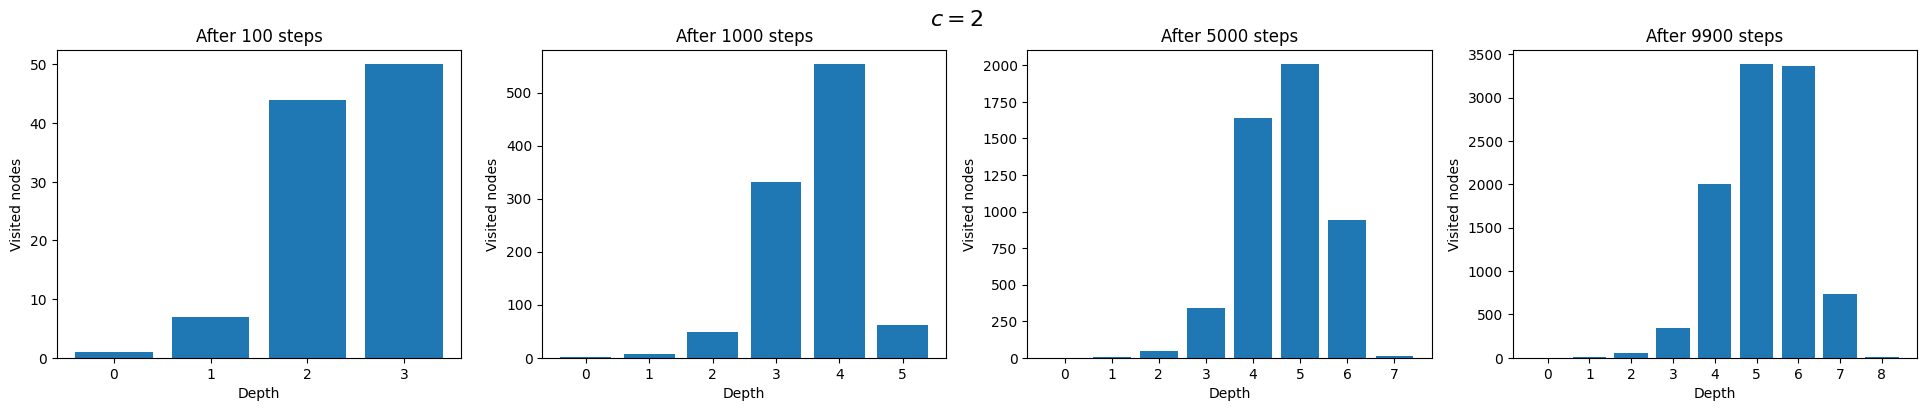

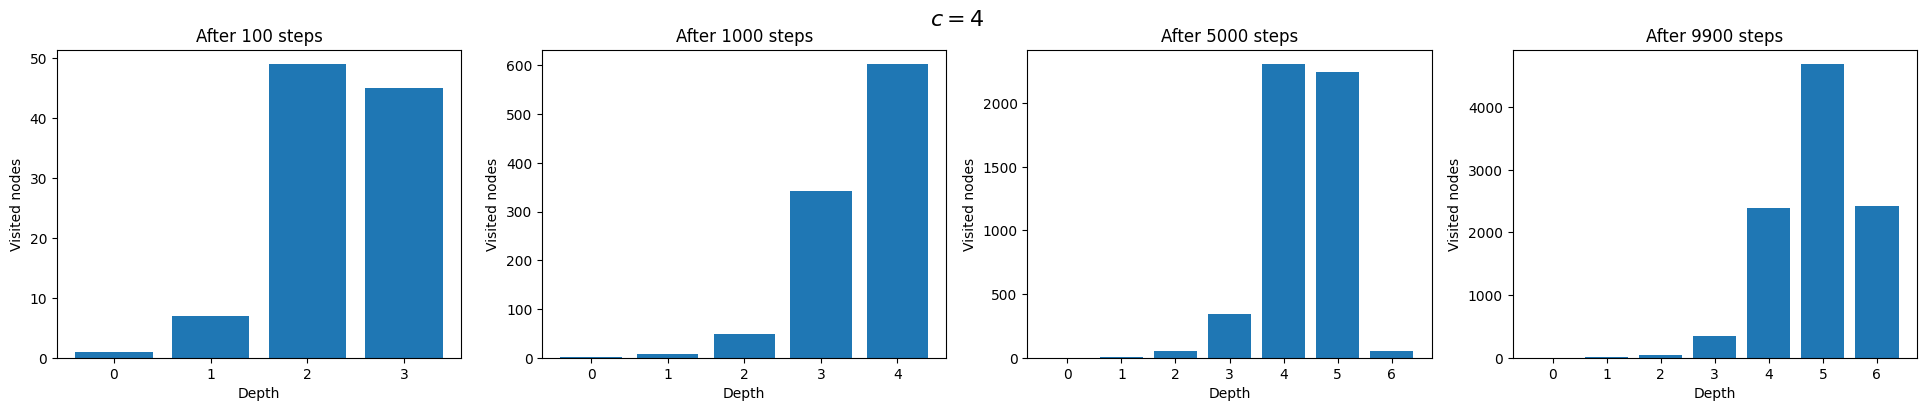

In [27]:
np.random.seed(111111)
mcts = MCTS(lambda state: UcbBandit(state, c_uct=2), random_simulation)
stats = record_mcts_stats(mcts)
plot_depth_histogram(stats, [1, 10, 50, 99], record_step=record_step, title=r'$c = 2$')

np.random.seed(111111)
mcts = MCTS(lambda state: UcbBandit(state, c_uct=4), random_simulation)
stats = record_mcts_stats(mcts)
plot_depth_histogram(stats, [1, 10, 50, 99], record_step=record_step, title=r'$c = 4$')

## MCTS and speed

**Question** How long does it take to perform 1000 samples in the root?

In [14]:
import time

mcts = MCTS(lambda state: UcbBandit(state, c_uct=2), random_simulation)
start = time.time_ns()
for i in range(1000):
    mcts.step(state)
duration = time.time_ns() - start
print("Performing 1000 samples took", duration / 1e9, "s")

Performing 1000 samples took 0.099922038 s


<ipython-input-2-038aa35af547>:62: RuntimeWarning: divide by zero encountered in log
  ucb_vals = (self.qs + self.c_uct * np.sqrt(np.log(total_visits) / self.visits))
<ipython-input-2-038aa35af547>:62: RuntimeWarning: invalid value encountered in sqrt
  ucb_vals = (self.qs + self.c_uct * np.sqrt(np.log(total_visits) / self.visits))
<ipython-input-2-038aa35af547>:62: RuntimeWarning: invalid value encountered in true_divide
  ucb_vals = (self.qs + self.c_uct * np.sqrt(np.log(total_visits) / self.visits))
<ipython-input-2-038aa35af547>:62: RuntimeWarning: divide by zero encountered in true_divide
  ucb_vals = (self.qs + self.c_uct * np.sqrt(np.log(total_visits) / self.visits))


**Question** How can we make the MCTS algorithm faster (in terms of time/sample)?
